In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
# Option to display all dataframes columns
pd.options.display.max_columns = None
import matplotlib.pyplot as plt

housing = pd.read_csv('Ames_HousePrice_cleaned.csv', index_col=0)
housing.shape

(2580, 59)

### Final model (Start here)

Linear model with 19 features is below (after dropping columns and doing lasso). This is my rough guess for the best features. 

In [2]:
#Simple stats model API linear regression on whole dataset; no train test split or cross-validation
import statsmodels.api as sm 

X=housing[['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtFinSF1', 
'TotalBsmtSF','KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 
'ScreenPorch','Class_2story_dev', 'Class_duplex','Lot_CulDSac', 'Foundation_Concrete']]
y=housing.SalePrice

X_add_const = sm.add_constant(X)
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())
print(ans.rsquared)

/Users/Matt/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     930.0
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:02:43   Log-Likelihood:                -29956.
No. Observations:                2580   AIC:                         5.995e+04
Df Residuals:                    2560   BIC:                         6.007e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.764e+05   5

Same model, but modeling against log of SalePrice

In [3]:
#Simple stats model API on entire dataset, trying to fit np.log(housing.SalePrice)
import statsmodels.api as sm 

X=housing[['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'ExterQual', 'BsmtFinSF1', 
'TotalBsmtSF','KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 
'ScreenPorch','Class_2story_dev', 'Class_duplex','Lot_CulDSac', 'Foundation_Concrete']]
y=np.log(housing.SalePrice)

X_add_const = sm.add_constant(X)
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())
print(ans.rsquared)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1292.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:02:43   Log-Likelihood:                 1767.3
No. Observations:                2580   AIC:                            -3497.
Df Residuals:                    2561   BIC:                            -3385.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0456    

### Start of feature selection process (Read on for nitty gritty details)

Started by doing train test splitting and cross validation on every feature. Consistently got at r^2 of ~0.88

In [4]:
#Whole data set, no split
from sklearn.linear_model import LinearRegression

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
lin = LinearRegression().fit(X,y)
print(lin.score(X,y))

0.8876308381267729


In [5]:
#Baseline model with all variables, with train test split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,shuffle=True)
lin = LinearRegression().fit(X_train,y_train)
print(lin.score(X_train,y_train))
print(lin.score(X_test,y_test))

0.8864374204793761
0.8864374998432968


In [6]:
#Baseline model with all variables (90-10 train test split) (not much difference)
from sklearn.linear_model import LinearRegression

lin = LinearRegression().fit(X_train,y_train)
print(lin.score(X_train,y_train))
print(lin.score(X_test,y_test))

0.8864374204793761
0.8864374998432968


Code for five fold cross validation

In [7]:
#K fold cross validation with scikit learn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
kf = KFold(n_splits=5,shuffle=True,random_state=42)

for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lin = LinearRegression().fit(X_train,y_train)
    print("Train r2: ",lin.score(X_train,y_train))
    print("Test r2: ",lin.score(X_test,y_test))



Train r2:  0.8864374204793761
Test r2:  0.8864374998432968
Train r2:  0.8980440677676648
Test r2:  0.8405802616258292
Train r2:  0.8861699444580762
Test r2:  0.8886632274573878
Train r2:  0.8848221966009314
Test r2:  0.894772876324662
Train r2:  0.8880798987466282
Test r2:  0.8792946363016549


In [8]:
#K fold cross validation with stats model API; using version of regression because it gives us p-values on individual coefficients
#Output is all the p-values of the various coefficients, sorted by mean p-value 
from sklearn.model_selection import KFold
import statsmodels.api as sm 


X= housing.drop(columns='SalePrice')
X= sm.add_constant(X)
y= housing.SalePrice
kf = KFold(n_splits=5,shuffle=True,random_state=42)
results=pd.DataFrame(index=housing.columns)

for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    ols = sm.OLS(y_train, X_train)
    ans = ols.fit()
    print("Train R2: ",ans.rsquared)
    results= pd.concat([results,ans.pvalues],axis=1)
results['Mean']=results.mean(axis=1)
results.sort_values(['Mean'],ascending=False)


Train R2:  0.8864374204793761
Train R2:  0.8980440677676649
Train R2:  0.8861699444580762
Train R2:  0.8848221966009314
Train R2:  0.8880798987466283


,0,0,0,0,0,Mean
FireplaceQu,8.096507e-01,9.489494e-01,9.052294e-01,4.383610e-01,9.765548e-01,8.157491e-01
YearRemodAdd,6.485412e-01,9.755034e-01,9.716150e-01,3.142082e-01,9.467709e-01,7.713277e-01
3SsnPorch,7.761081e-01,6.793531e-01,9.410952e-01,4.871255e-01,9.395985e-01,7.646561e-01
PavedDrive,7.755261e-01,9.563179e-01,7.082893e-01,6.582061e-01,6.806121e-01,7.557903e-01
Class_1.5story,9.927920e-01,6.703099e-01,5.924804e-01,9.778888e-01,5.005962e-01,7.468135e-01
Baths,5.731020e-01,7.684513e-01,8.458439e-01,9.843909e-01,5.238145e-01,7.391205e-01
ExterCond,2.136511e-01,9.547990e-01,8.818727e-01,4.712412e-01,8.853337e-01,6.813795e-01
GarageQual,6.208846e-01,3.203128e-01,5.227863e-01,8.876588e-01,7.311600e-01,6.165605e-01
Fence,8.125390e-01,6.644502e-01,5.057891e-01,4.619880e-01,4.421461e-01,5.773825e-01
GarageCars,5.345200e-01,8.913593e-01,2.227036e-01,5.983303e-01,5.301194e-01,5.554065e-01


In [9]:
#Same as cell above, five fold cross-validation, but scaling the data before regressing.
#Turns out, it really makes no difference, you get pretty much the same answer, I think beause stats model scales by default
from sklearn.model_selection import KFold
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

#Get features and response
X= housing.drop(columns='SalePrice')
y= housing.SalePrice.to_numpy().reshape(-1,1)

#Scale X and y
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)
scaler_y = StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)

#Convert back to dataframes
X= pd.DataFrame(data=X_scaled,index=X.index,columns=X.columns)
y= pd.DataFrame(data=y_scaled,index=X.index,columns=['SalePrice'])

#Add constant for stats model API
X= sm.add_constant(X)

#Initialize empty results dataframe and K-folds object
kf = KFold(n_splits=5,shuffle=True,random_state=42)
results=pd.DataFrame(index=housing.columns)

#Train statsmodel objects
for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    ols = sm.OLS(y_train, X_train)
    ans = ols.fit()
    print(ans.rsquared)
    results= pd.concat([results,ans.pvalues],axis=1)
    #print(ans.pvalues.sort_values(ascending=False))
results['Mean']=results.mean(axis=1)
results.sort_values(['Mean'],ascending=False)


0.8864374204793761
0.8980440677676649
0.8861699444580762
0.8848221966009313
0.8880798987466282


,0,0,0,0,0,Mean
FireplaceQu,8.096507e-01,9.489494e-01,9.052294e-01,4.383610e-01,9.765548e-01,8.157491e-01
YearRemodAdd,6.485412e-01,9.755034e-01,9.716150e-01,3.142082e-01,9.467709e-01,7.713277e-01
3SsnPorch,7.761081e-01,6.793531e-01,9.410952e-01,4.871255e-01,9.395985e-01,7.646561e-01
PavedDrive,7.755261e-01,9.563179e-01,7.082893e-01,6.582061e-01,6.806121e-01,7.557903e-01
Class_1.5story,9.927920e-01,6.703099e-01,5.924804e-01,9.778888e-01,5.005962e-01,7.468135e-01
const,7.689250e-01,7.146174e-01,5.902295e-01,8.581581e-01,7.780947e-01,7.420049e-01
Baths,5.731020e-01,7.684513e-01,8.458439e-01,9.843909e-01,5.238145e-01,7.391205e-01
ExterCond,2.136511e-01,9.547990e-01,8.818727e-01,4.712412e-01,8.853337e-01,6.813795e-01
GarageQual,6.208846e-01,3.203128e-01,5.227863e-01,8.876588e-01,7.311600e-01,6.165605e-01
Fence,8.125390e-01,6.644502e-01,5.057891e-01,4.619880e-01,4.421461e-01,5.773825e-01


**First round of drops**

Same idea as before, but now dropping 11 of the least significant features and re-running the pipeline.

In [10]:
from sklearn.model_selection import KFold
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

#Columns to drop
drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch']

#Get features and response
X= housing.drop(columns=drop_columns)
y= housing.SalePrice.to_numpy().reshape(-1,1)

#Scale X and y
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)
scaler_y = StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)

#Convert back to dataframes
X= pd.DataFrame(data=X_scaled,index=X.index,columns=X.columns)
y= pd.DataFrame(data=y_scaled,index=X.index,columns=['SalePrice'])

#Add constant for stats model API
X= sm.add_constant(X)

#Initialize empty results dataframe and K-folds object
kf = KFold(n_splits=5,shuffle=True,random_state=42)
results=pd.DataFrame(index=housing.columns)

#Train statsmodel objects
for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    ols = sm.OLS(y_train, X_train)
    ans = ols.fit()
    print(ans.rsquared)
    results= pd.concat([results,ans.pvalues],axis=1)
    #print(ans.pvalues.sort_values(ascending=False))
results['Mean']=results.mean(axis=1)
results.sort_values(['Mean'],ascending=False)



0.8862119409682975
0.8974863198202291
0.8858886385854005
0.8844156638920795
0.8876416930364253


,0,0,0,0,0,Mean
const,7.868969e-01,7.170758e-01,5.773519e-01,8.876259e-01,7.738900e-01,7.485681e-01
Baths,4.630459e-01,7.927297e-01,9.246633e-01,9.365249e-01,4.827934e-01,7.199514e-01
Class_1.5story,8.916821e-01,7.552050e-01,5.551893e-01,9.015156e-01,4.504736e-01,7.108131e-01
ExterCond,2.081451e-01,8.934192e-01,8.022982e-01,4.723276e-01,9.360438e-01,6.624468e-01
LandSlope,8.882036e-03,8.194175e-01,1.377872e-01,4.270697e-02,4.774994e-01,2.972586e-01
CentralAir,6.640830e-02,3.374210e-01,5.692006e-01,2.699683e-01,1.458763e-01,2.777749e-01
Class_split,1.765926e-01,4.900997e-01,1.541899e-01,2.168321e-01,3.467145e-01,2.768858e-01
OpenPorchSF,8.838484e-02,4.431670e-01,2.882142e-01,3.034568e-01,4.155759e-02,2.329561e-01
LandContour,9.713752e-01,1.578967e-03,4.288589e-02,1.173405e-01,2.056704e-02,2.307495e-01
Lot_Corner,2.498421e-01,6.636828e-02,3.602646e-01,3.893663e-01,7.330561e-02,2.278294e-01


**Second round of drops**

21 features dropped. Of those that remain, the p-values are getting smaller and more significant, which hopefully means the model is focusing on more relevant information.

In [11]:
#K fold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

#Columns to drop
drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
                'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch',
               'ExterCond','LandSlope','CentralAir','OpenPorchSF','LandContour',
               'Electrical','MSZoning','RoofStyle','LotShape','HeatingQC']

X=housing.drop(columns=drop_columns)
y=housing.SalePrice
kf = KFold(n_splits=5,shuffle=True,random_state=42)

for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    lin = LinearRegression().fit(X_train,y_train)
    print(lin.score(X_train,y_train))
    print(lin.score(X_test,y_test))

0.8843985105156479
0.8871966046948278
0.8957937024914587
0.8438128069765551
0.8842117591320253
0.8884707227293948
0.8827047549812084
0.896248902738785
0.8860306001388811
0.8822524794388009


In [12]:
from sklearn.model_selection import KFold
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

#Columns to drop
drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
                'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch',
               'ExterCond','LandSlope','CentralAir','OpenPorchSF','LandContour',
               'Electrical','MSZoning','RoofStyle','LotShape','HeatingQC']

#Get features and response
X= housing.drop(columns=drop_columns)
y= housing.SalePrice.to_numpy().reshape(-1,1)

#Scale X and y
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)
scaler_y = StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)

#Convert back to dataframes
X= pd.DataFrame(data=X_scaled,index=X.index,columns=X.columns)
y= pd.DataFrame(data=y_scaled,index=X.index,columns=['SalePrice'])

#Add constant for stats model API
X= sm.add_constant(X)

#Initialize empty results dataframe and K-folds object
kf = KFold(n_splits=5,shuffle=True,random_state=42)
results=pd.DataFrame(index=housing.columns)

#Train statsmodel objects
for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    ols = sm.OLS(y_train, X_train)
    ans = ols.fit()
    print(ans.rsquared)
    results= pd.concat([results,ans.pvalues],axis=1)
    #print(ans.pvalues.sort_values(ascending=False))
results['Mean']=results.mean(axis=1)
results.sort_values(['Mean'],ascending=False)

0.884398510515648
0.8957937024914588
0.8842117591320253
0.8827047549812083
0.8860306001388811


,0,0,0,0,0,Mean
const,7.159548e-01,7.230556e-01,5.773881e-01,9.272826e-01,7.883891e-01,7.464140e-01
Baths,5.962273e-01,7.062671e-01,8.958627e-01,8.261684e-01,5.705546e-01,7.190160e-01
Class_1.5story,5.064471e-01,3.543689e-01,2.441727e-01,8.565993e-01,3.094941e-01,4.542164e-01
Lot_Corner,2.639452e-01,8.564986e-02,2.770785e-01,3.302905e-01,7.039602e-02,2.054720e-01
Class_split,1.233631e-01,2.720177e-01,5.715483e-02,1.214955e-01,2.261351e-01,1.600333e-01
Lot_FR,1.163151e-01,1.046847e-01,4.962156e-02,1.264703e-02,2.603176e-01,1.087172e-01
Foundation_Other,4.603184e-03,3.119620e-02,3.025650e-02,4.481087e-01,2.892526e-03,1.034114e-01
LowQualFinSF,1.235614e-01,2.072310e-04,7.696896e-02,1.518206e-02,1.339558e-01,6.997509e-02
GarageCond,1.110417e-02,2.373329e-01,2.846644e-04,3.584336e-02,1.943146e-02,6.079931e-02
BsmtUnfSF,1.031904e-01,2.512702e-02,4.545350e-03,2.748213e-02,1.308733e-01,5.824363e-02


**Third round of drops**

31 features dropped.

In [13]:
from sklearn.model_selection import KFold
import statsmodels.api as sm 
from sklearn.preprocessing import StandardScaler

#Columns to drop
drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
                'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch',
               'ExterCond','LandSlope','CentralAir','OpenPorchSF','LandContour',
               'Electrical','MSZoning','RoofStyle','LotShape','HeatingQC',
               'Baths', 'Class_1.5story', 'Lot_Corner', 'Class_split','Lot_FR',
               'Foundation_Other', 'LowQualFinSF', 'GarageCond', 'BsmtUnfSF','WoodDeckSF']

#Get features and response
X= housing.drop(columns=drop_columns)
y= housing.SalePrice.to_numpy().reshape(-1,1)

#Scale X and y
scaler_X = StandardScaler().fit(X)
X_scaled = scaler_X.transform(X)
scaler_y = StandardScaler().fit(y)
y_scaled = scaler_y.transform(y)

#Convert back to dataframes
X= pd.DataFrame(data=X_scaled,index=X.index,columns=X.columns)
y= pd.DataFrame(data=y_scaled,index=X.index,columns=['SalePrice'])

#Add constant for stats model API
X= sm.add_constant(X)

#Initialize empty results dataframe and K-folds object
kf = KFold(n_splits=5,shuffle=True,random_state=42)
results=pd.DataFrame(index=housing.columns)

#Train statsmodel objects
for train_idx, test_idx in kf.split(X,y):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
    ols = sm.OLS(y_train, X_train)
    ans = ols.fit()
    print(ans.rsquared)
    results= pd.concat([results,ans.pvalues],axis=1)
    #print(ans.pvalues.sort_values(ascending=False))
results['Mean']=results.mean(axis=1)
results.sort_values(['Mean'],ascending=False)

0.8826954833449628
0.8942082167052883
0.8816502646428629
0.8812099244801809
0.8844532019998205


,0,0,0,0,0,Mean
const,7.305580e-01,7.545677e-01,6.433739e-01,8.251386e-01,7.205433e-01,7.348363e-01
Class_2story,1.342487e-01,1.807531e-01,2.632726e-02,5.028459e-02,1.212187e-01,1.025665e-01
KitchenAbvGr,3.163279e-02,6.407903e-02,3.165690e-02,7.760094e-03,3.127305e-02,3.328037e-02
TotRmsAbvGrd,1.412281e-01,1.147726e-02,4.294890e-04,3.261033e-03,3.193512e-03,3.191788e-02
Class_duplex,2.110321e-02,1.158237e-03,1.832222e-02,2.357814e-02,9.049031e-03,1.464217e-02
ScreenPorch,3.159979e-05,6.503720e-03,5.133070e-04,6.388648e-04,5.929317e-04,1.656085e-03
Foundation_Concrete,3.117394e-04,2.292942e-03,4.883614e-04,4.629675e-03,1.711523e-04,1.578774e-03
Lot_CulDSac,3.057573e-03,5.342891e-06,9.027027e-06,4.682185e-04,7.670743e-05,7.233737e-04
BsmtFinSF2,1.601528e-06,1.887444e-06,1.533697e-05,1.407231e-05,1.585859e-03,3.237514e-04
BsmtQual,3.448589e-06,4.502964e-05,2.747015e-06,1.464561e-03,6.006088e-06,3.043585e-04


**Overall look at the remaining coefficients**

Running this so we can see the size of the coefficients instead of just p-values

In [14]:
#Simple stats model API on entire dataset
import statsmodels.api as sm 
drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
                'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch',
               'ExterCond','LandSlope','CentralAir','OpenPorchSF','LandContour',
               'Electrical','MSZoning','RoofStyle','LotShape','HeatingQC',
               'Baths', 'Class_1.5story', 'Lot_Corner', 'Class_split','Lot_FR',
               'Foundation_Other', 'LowQualFinSF', 'GarageCond', 'BsmtUnfSF','WoodDeckSF']

X=housing.drop(columns=drop_columns)
y=housing.SalePrice

X_add_const = sm.add_constant(X)
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())
print(ans.rsquared)


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     696.2
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:02:47   Log-Likelihood:                -29841.
No. Observations:                2580   AIC:                         5.974e+04
Df Residuals:                    2551   BIC:                         5.991e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -6.709e+05   5

### Further feature selection

**Lasso on remaining features**

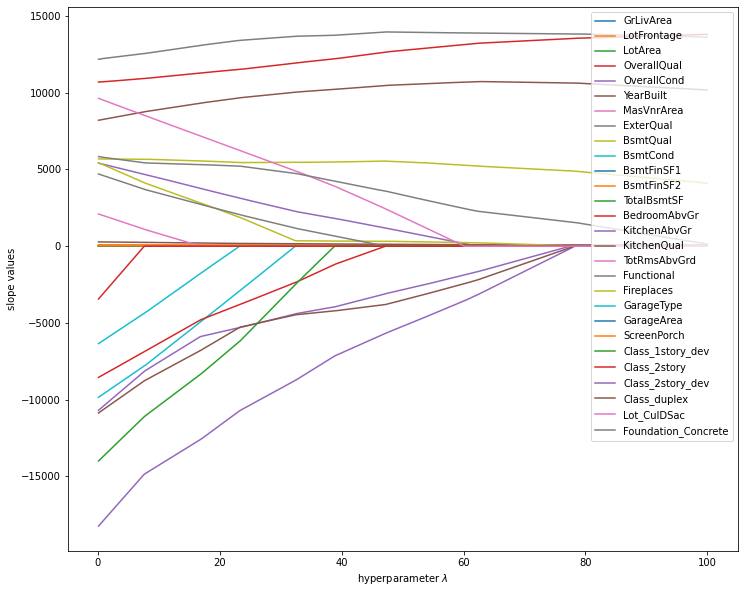

In [15]:
#Scanning from 0.1 to 100 initially
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lasso  = Lasso()
alphas = np.linspace(0.1,100,1000)
lasso.set_params(normalize=True)
coefs_lasso  = []

drop_columns = ['SalePrice','FireplaceQu','YearRemodAdd','3SsnPorch','PavedDrive',
                'GarageQual','Fence','GarageCars','GarageFinish','PoolArea','EnclosedPorch',
               'ExterCond','LandSlope','CentralAir','OpenPorchSF','LandContour',
               'Electrical','MSZoning','RoofStyle','LotShape','HeatingQC',
               'Baths', 'Class_1.5story', 'Lot_Corner', 'Class_split','Lot_FR',
               'Foundation_Other', 'LowQualFinSF', 'GarageCond', 'BsmtUnfSF','WoodDeckSF']

X=housing.drop(columns=drop_columns)
y=housing.SalePrice

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, y)  
        coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X.columns)  
plt.figure(figsize=(12,10))
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)  

**Picked a lambda of 50 as a value that would eliminate most features and just keep the most signficant ones**

In [16]:
lasso_50 = coefs_lasso.loc[coefs_lasso.index>50].head(1)
lasso_50

,GrLivArea,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageArea,ScreenPorch,Class_1story_dev,Class_2story,Class_2story_dev,Class_duplex,Lot_CulDSac,Foundation_Concrete
50.0,45.159896,37.271341,0.462019,12753.393622,963.394837,116.44108,25.21077,13937.429982,300.917765,-0.0,22.95171,0.0,19.62206,-0.0,-2842.242101,10520.414173,0.0,0.0,5494.997356,0.0,27.870732,1.890921,-0.0,0.0,-5224.149324,-3515.213653,1908.644748,3336.658608


In [17]:
lasso_50.columns

Index(['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtCond',
       'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'GarageType', 'GarageArea', 'ScreenPorch',
       'Class_1story_dev', 'Class_2story', 'Class_2story_dev', 'Class_duplex',
       'Lot_CulDSac', 'Foundation_Concrete'],
      dtype='object')

**These are the features selected to run the last model (same as at the top)**

In [18]:
['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtQual', 'BsmtFinSF1', 
'TotalBsmtSF','KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 
'ScreenPorch','Class_2story_dev', 'Class_duplex','Lot_CulDSac', 'Foundation_Concrete']

['GrLivArea',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'ExterQual',
 'BsmtQual',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'KitchenAbvGr',
 'KitchenQual',
 'Fireplaces',
 'GarageArea',
 'ScreenPorch',
 'Class_2story_dev',
 'Class_duplex',
 'Lot_CulDSac',
 'Foundation_Concrete']

In [19]:
#Simple stats model API on entire dataset
import statsmodels.api as sm 

X=housing[['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'MasVnrArea', 'ExterQual', 'BsmtFinSF1', 
'TotalBsmtSF','KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 
'ScreenPorch','Class_2story_dev', 'Class_duplex','Lot_CulDSac', 'Foundation_Concrete']]
y=housing.SalePrice

X_add_const = sm.add_constant(X)
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())
print(ans.rsquared)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     930.0
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:02:55   Log-Likelihood:                -29956.
No. Observations:                2580   AIC:                         5.995e+04
Df Residuals:                    2560   BIC:                         6.007e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -5.764e+05   5

In [20]:
#Simple stats model API on entire dataset, trying to fit np.log(housing.SalePrice)
import statsmodels.api as sm 

X=housing[['GrLivArea', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
'YearBuilt', 'ExterQual', 'BsmtFinSF1', 
'TotalBsmtSF','KitchenAbvGr', 'KitchenQual','Fireplaces', 'GarageArea', 
'ScreenPorch','Class_2story_dev', 'Class_duplex','Lot_CulDSac', 'Foundation_Concrete']]
y=np.log(housing.SalePrice)

X_add_const = sm.add_constant(X)
ols = sm.OLS(y, X_add_const)
ans = ols.fit()
print(ans.summary())
print(ans.rsquared)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     1292.
Date:                Sun, 22 Nov 2020   Prob (F-statistic):               0.00
Time:                        21:02:55   Log-Likelihood:                 1767.3
No. Observations:                2580   AIC:                            -3497.
Df Residuals:                    2561   BIC:                            -3385.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.0456    

### Statistical tests (F Regression and Mutual Info)

Copied the code from the model selection jumpstart to try to get a sense of what features to keep. The results of the tests seem largely consistent with the p-values of the coefficients from multiple linear regression, but probably ranked slightly differently. Hard to understand why they're ranked differently without getting into the weeds of the tests, so I largely ignored them.

In [21]:
from sklearn.feature_selection import f_regression

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
F_values, p_values = f_regression(X,y)
pd.Series(p_values, index=X.columns).sort_values(ascending=False)

Lot_Corner              9.892608e-01
Lot_FR                  6.452494e-01
ExterCond               5.671959e-01
BsmtFinSF2              2.497410e-01
LowQualFinSF            1.173873e-01
PoolArea                1.172748e-01
3SsnPorch               1.124139e-01
Class_split             2.052986e-02
LandContour             6.442264e-05
LandSlope               6.402864e-05
Class_1story_dev        8.875970e-06
OverallCond             2.667977e-07
Functional              1.237722e-07
KitchenAbvGr            6.420379e-09
ScreenPorch             6.034979e-10
EnclosedPorch           3.375427e-10
Class_duplex            3.449142e-12
Class_2story_dev        1.959764e-12
Lot_CulDSac             2.439378e-13
BedroomAbvGr            9.043503e-15
Fence                   8.668212e-15
BsmtUnfSF               8.441921e-18
LotFrontage             1.222213e-19
Class_1.5story          3.627284e-20
BsmtCond                1.864986e-26
RoofStyle               2.664322e-31
Electrical              7.231133e-34
M

In [22]:
from sklearn.feature_selection import mutual_info_classif

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
mutual_scores = mutual_info_classif(X,y)
pd.Series(mutual_scores, index=X.columns).sort_values()


3SsnPorch              0.000000
ScreenPorch            0.000000
Lot_FR                 0.000000
LowQualFinSF           0.002856
Class_duplex           0.004940
Class_2story_dev       0.005109
LandSlope              0.005873
Lot_Corner             0.014964
BsmtFinSF2             0.019677
PoolArea               0.020329
Class_split            0.022607
Class_1story_dev       0.022701
LandContour            0.025255
EnclosedPorch          0.025923
BsmtUnfSF              0.031609
Lot_CulDSac            0.042168
Class_1.5story         0.049901
Fence                  0.051067
RoofStyle              0.061435
WoodDeckSF             0.070441
Electrical             0.071162
MasVnrArea             0.093416
Foundation_Other       0.097877
LotArea                0.113933
BsmtFinSF1             0.129807
LotFrontage            0.140506
OpenPorchSF            0.150222
MSZoning               0.153498
Class_2story           0.236619
TotalBsmtSF            0.276100
YearBuilt              0.331503
GarageAr

In [23]:
from sklearn.feature_selection import mutual_info_classif

X=housing.drop(columns='SalePrice')
y=housing.SalePrice
mutual_scores = mutual_info_classif(X,y,discrete_features=True)
pd.Series(mutual_scores, index=X.columns).sort_values()

PoolArea               0.021050
3SsnPorch              0.074591
Lot_FR                 0.075009
LowQualFinSF           0.081068
KitchenAbvGr           0.087066
Class_split            0.094339
LandSlope              0.095554
Class_2story_dev       0.097817
Class_duplex           0.098117
Class_1story_dev       0.107982
Lot_CulDSac            0.108282
LandContour            0.138888
Class_1.5story         0.139068
Electrical             0.143573
CentralAir             0.144195
PavedDrive             0.157661
Lot_Corner             0.174149
Foundation_Other       0.178662
Functional             0.184885
RoofStyle              0.207420
ExterCond              0.210626
MSZoning               0.216406
GarageCond             0.228758
BsmtCond               0.247956
GarageQual             0.254975
Class_2story           0.262183
LotShape               0.271586
Fence                  0.303221
Foundation_Concrete    0.350783
GarageType             0.378760
Fireplaces             0.455569
ScreenPo

### Lasso on all features 

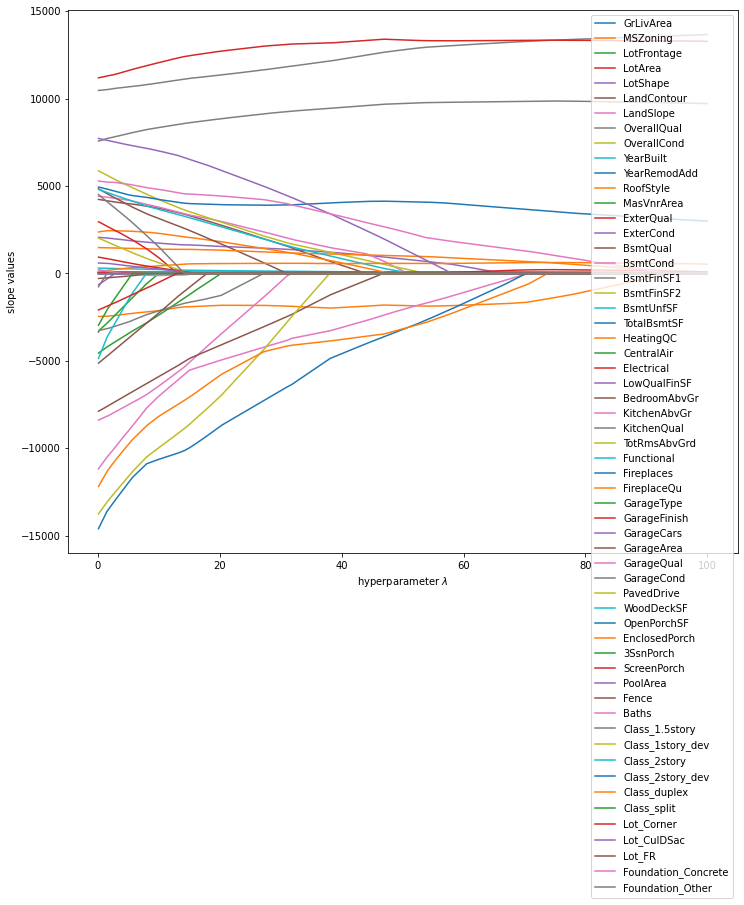

In [24]:
#Scanning from 0.1 to 100 initially
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lasso  = Lasso()
alphas = np.linspace(0.1,100,1000)
lasso.set_params(normalize=True)
coefs_lasso  = []
X=housing.drop(columns='SalePrice')
y=housing.SalePrice

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, y)  
        coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X.columns)  
plt.figure(figsize=(12,10))
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)  

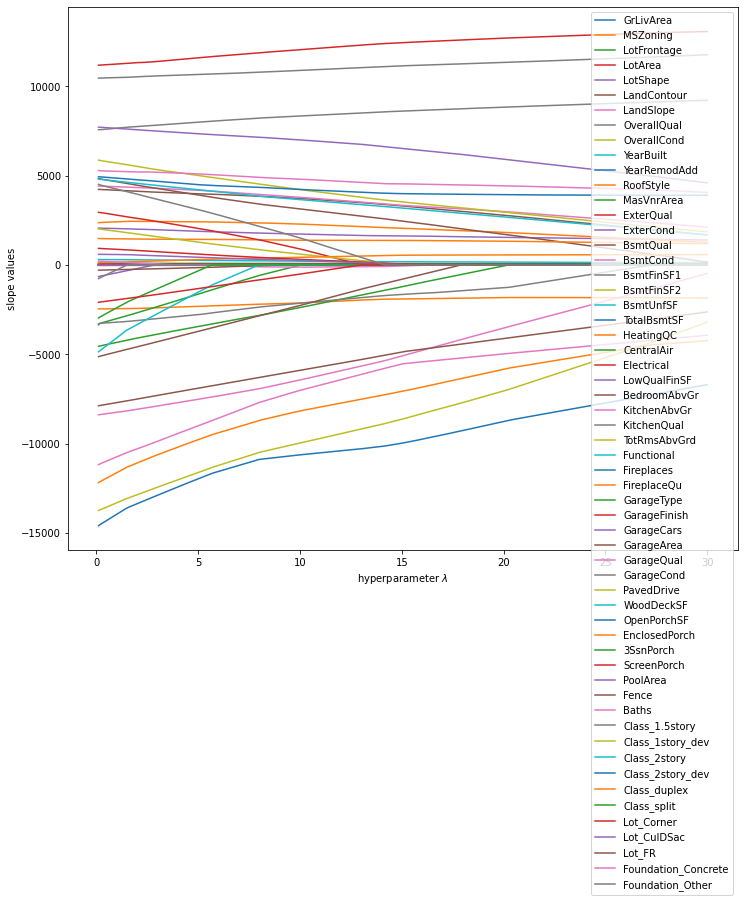

In [25]:
#Zoom in on values less than 30 for lambda
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
lasso  = Lasso()
alphas = np.linspace(0.1,30,1000)
lasso.set_params(normalize=True)
coefs_lasso  = []
X=housing.drop(columns='SalePrice')
y=housing.SalePrice

for alpha in alphas:
        lasso.set_params(alpha=alpha)
        lasso.fit(X, y)  
        coefs_lasso.append(lasso.coef_)

coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X.columns)  
plt.figure(figsize=(12,10))
for name in coefs_lasso.columns:
    plt.plot(coefs_lasso.index, coefs_lasso[name], label=name)
plt.xlabel(r'hyperparameter $\lambda$')
plt.ylabel(r'slope values')
plt.legend(loc=1)  